In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from pathlib import Path
import os
import itertools
import re


In [4]:

print(os.getcwd())
if os.getcwd().split('/')[-1] != "data_manipulation":
    os.chdir("./data_manipulation")
print(os.getcwd())

/home/cognitia/Desktop/Work/PhD/PIAE-SDE/data_manipulation
/home/cognitia/Desktop/Work/PhD/PIAE-SDE/data_manipulation


In [20]:
data_path = Path("./other_sites/woodwalton/data.parquet")
main_data_path = Path("./complete_data.parquet")

site_data = pd.read_parquet(data_path)
main_data = pd.read_parquet(main_data_path)


In [21]:
for col in site_data.columns:
    site_data[col] = site_data[col].replace(-9999, np.nan)

for col in main_data.columns:
    main_data[col] = main_data[col].replace(-9999, np.nan)

In [22]:
site_data.columns, main_data.columns

(Index(['site', 'TIMESTAMP_START', 'TIMESTAMP_END', 'TS_3_1_1', 'TS_1_2_1',
        'TS_2_2_1', 'TS_3_2_1', 'TS_1_3_1', 'TS_2_3_1', 'TS_3_3_1',
        ...
        'GPP_NT_VUT_USTAR05', 'GPP_NT_VUT_USTAR95', 'RECO_DT_VUT_REF',
        'RECO_DT_VUT_USTAR50', 'RECO_DT_VUT_USTAR05', 'RECO_DT_VUT_USTAR95',
        'GPP_DT_VUT_REF', 'GPP_DT_VUT_USTAR50', 'GPP_DT_VUT_USTAR05',
        'GPP_DT_VUT_USTAR95'],
       dtype='object', length=130),
 Index(['DateTime', 'NEE', 'NEE_unc', 'LE', 'LE_unc', 'H', 'H_unc', 'Tau',
        'Tau_unc', 'CO2_strg', 'LE_strg', 'H_strg', 'Pa', 'Ta', 'RH', 'VPD',
        'Rnet', 'Rg', 'G1', 'G2', 'G3', 'G4', 'Tsoil1', 'Tsoil2', 'VWC_1',
        'VWC2', 'Precipitation', 'Windspeed', 'Winddir', 'FootprintFraction',
        'Ustar', 'TKE', 'Tstar', 'L', 'zL', 'NEE_filled', 'NEE_filled_sd',
        'LE_filled', 'LE_filled_sd', 'H_filled', 'H_filled_sd', 'TER', 'GEP',
        'Day/Night', 'Date', 'Time (past local midnight)', 'Julian Day',
        'Julian Century', 'G

### Columns used in training
```
['Ta', 'H', 'Tau', 'RH', 'VPD', 'Rg', 'Ustar', 'Tsoil1', 'Tsoil2']
```

# This section is for sites with the FLUXNET2015 data format

In [23]:
def preprocess_site_data(site_data):
    # Mapping from main_data to possible site_data columns
    main_to_fluxnet = {
        'NEE': ['NEE_VUT_REF', 'NEE', 'NEE_VUT_USTAR50', 'NEE_VUT_USTAR05', 'NEE_VUT_USTAR95'],
        'H': ['H', 'H_F_MDS'],
        'Tau': ['TAU'],
        'LE': ['LE', 'LE_F_MDS'],
        'RH': ['RH', 'RH_F_MDS'],
        'VPD': ['VPD', 'VPD_F_MDS'],
        'Ustar': ['USTAR'],
        'Ta': ['TA', 'TA_F_MDS'],
        # Rg handled separately
    }
    # 1. Select and rename columns
    final_cols = {}
    for main_col, candidates in main_to_fluxnet.items():
        for cand in candidates:
            if cand in site_data.columns:
                final_cols[main_col] = cand
                break

    # 2. Handle Tsoil: mean of shallowest TS_* at each position
    ts_cols = [col for col in site_data.columns if col.startswith('TS_')]
    parsed = []
    for col in ts_cols:
        m = re.match(r'TS_(\d+)_(\d+)_(\d+)', col)
        if m:
            position, depth, c = map(int, m.groups())
            parsed.append((col, position, depth, c))
    shallowest = {}
    for col, position, depth, c in parsed:
        if position not in shallowest or depth < shallowest[position][1]:
            shallowest[position] = (col, depth)
    shallowest_cols = [v[0] for v in shallowest.values()]
    site_data['Tsoil1'] = site_data[shallowest_cols].mean(axis=1)

    
    # 4. Convert TIMESTAMP_START to DateTime (matching main_data format)
    if 'TIMESTAMP_START' in site_data.columns:
        site_data['DateTime'] = pd.to_datetime(site_data['TIMESTAMP_START'].astype(str), format='%Y%m%d%H%M')
    elif 'TIMESTAMP_END' in site_data.columns:
        site_data['DateTime'] = pd.to_datetime(site_data['TIMESTAMP_END'].astype(str), format='%Y%m%d%H%M')
    else:
        raise ValueError("No TIMESTAMP_START or TIMESTAMP_END column found in site_data.")

    # 5. Calculate Rg as SW_IN - SW_OUT + LW_IN - LW_OUT
    for col in ['SW_IN', 'SW_OUT', 'LW_IN', 'LW_OUT']:
        if col not in site_data.columns:
            raise ValueError(f"Column {col} not found in site_data, cannot compute Rg.")
    site_data['Rg'] = (site_data['SW_IN'] - site_data['SW_OUT']) + (site_data['LW_IN'] - site_data['LW_OUT'])

    # 6. Build final DataFrame
    output_cols = ['DateTime'] + list(final_cols.keys()) + ['Tsoil1', 'Rg']
    output_df = pd.DataFrame()
    output_df['DateTime'] = site_data['DateTime']
    for main_col in final_cols:
        output_df[main_col] = site_data[final_cols[main_col]]
    output_df['Tsoil1'] = site_data['Tsoil1']
    output_df['Rg'] = site_data['Rg']
    
    return output_df


In [24]:
processed_site_data = preprocess_site_data(site_data)
processed_site_data.to_parquet(data_path.parent.joinpath("processed_data.parquet"))


/tmp/ipykernel_89900/3941079359.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  site_data['Tsoil1'] = site_data[shallowest_cols].mean(axis=1)
/tmp/ipykernel_89900/3941079359.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  site_data['DateTime'] = pd.to_datetime(site_data['TIMESTAMP_START'].astype(str), format='%Y%m%d%H%M')
/tmp/ipykernel_89900/3941079359.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joini

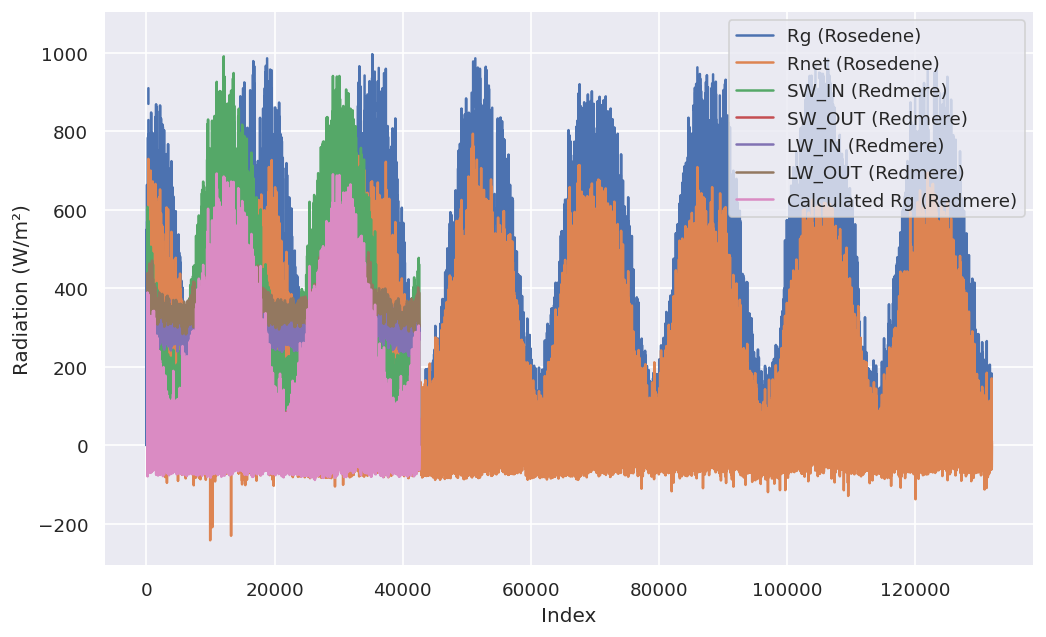

In [12]:
plt.figure(figsize=(10, 6), dpi=120)
main_data.Rg.plot()
main_data.Rnet.plot()
site_data.SW_IN.plot()
site_data.SW_OUT.plot()
site_data.LW_IN.plot()
site_data.LW_OUT.plot()
processed_site_data.Rg.plot()
plt.legend(['Rg (Rosedene)', 'Rnet (Rosedene)', 'SW_IN (Redmere)', 'SW_OUT (Redmere)', 'LW_IN (Redmere)', 'LW_OUT (Redmere)', 'Calculated Rg (Redmere)'])
plt.xlabel('Index')
plt.ylabel('Radiation (W/m²)')
plt.savefig('Rg_comparison.png')
plt.show()


In [ ]:
print(site_data.SW_IN.min(), site_data.SW_IN.max())
print(site_data.SW_OUT.min(), site_data.SW_OUT.max())
print(site_data.LW_IN.min(), site_data.LW_IN.max())
print(site_data.LW_OUT.min(), site_data.LW_OUT.max())


In [13]:
main_to_fluxnet = {
    'NEE': ['NEE_VUT_REF', 'NEE', 'NEE_VUT_USTAR50', 'NEE_VUT_USTAR05', 'NEE_VUT_USTAR95'],
    'H': ['H', 'H_F_MDS'],
    'Tau': ['TAU'],
    'RH': ['RH', 'RH_F_MDS'],
    'VPD': ['VPD', 'VPD_F_MDS'],
    'Rg': ['SW_IN', 'SW_IN_F_MDS'],
    'Ustar': ['USTAR'],
    'Tsoil1': ['TS_1_1_1', 'TS_2_1_1'],
    'Tsoil2': ['TS_1_2_1', 'TS_2_2_1'],
    'Ta': ['TA', 'TA_F_MDS'],
}

In [14]:

def compare_main_to_site(main_data, site_data, main_to_fluxnet, main_col, n_points=500):
    """
    Plots the selected column from main_data against all possible candidate columns from site_data.
    Args:
        main_data: DataFrame containing the main data.
        site_data: DataFrame containing the site data.
        main_to_fluxnet: Dictionary mapping main_data columns to possible site_data columns.
        main_col: The column name in main_data to compare.
        n_points: Number of points to plot (for speed/clarity).
    """
    candidates = main_to_fluxnet.get(main_col, [])
    if not candidates:
        print(f"No candidates found for {main_col}")
        return

    # Prepare data (align by index, drop NaNs)
    main_series = main_data[main_col].dropna()
    fig, axes = plt.subplots(1, len(candidates), figsize=(5 * len(candidates), 4), squeeze=False)
    for i, cand in enumerate(candidates):
        if cand not in site_data.columns:
            axes[0, i].set_title(f"{cand}\n(not found)")
            axes[0, i].axis('off')
            continue
        site_series = site_data[cand].dropna()
        # Align by index (if possible)
        df = main_series.to_frame('main').join(site_series.to_frame('site'), how='inner')
        if df.empty:
            axes[0, i].set_title(f"{cand}\n(no overlap)")
            axes[0, i].axis('off')
            continue
        # Optionally subsample for speed
        df = df.sample(min(n_points, len(df)), random_state=0)
        axes[0, i].scatter(df['main'], df['site'], alpha=0.5)
        axes[0, i].set_xlabel(f"{main_col} (main_data)")
        axes[0, i].set_ylabel(f"{cand} (site_data)")
        axes[0, i].set_title(f"{main_col} vs {cand}")
    plt.tight_layout()
    plt.show()

In [ ]:
# Example usage:
compare_main_to_site(main_data, site_data, main_to_fluxnet, 'Rg')





In [188]:
def plot_tsoil_comparison(main_data):
    plt.figure(figsize=(12, 5))
    plt.plot(main_data['Tsoil1'], label='Tsoil1', alpha=0.7)
    plt.plot(main_data['Tsoil2'], label='Tsoil2', alpha=0.7)
    plt.xlabel('Index')
    plt.ylabel('Soil Temperature (°C)')
    plt.title('Comparison of Tsoil1 and Tsoil2 from main_data')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_tsoil_scatter(main_data):
    plt.figure(figsize=(6, 6))
    plt.scatter(main_data['Tsoil1'], main_data['Tsoil2'], alpha=0.5)
    plt.xlabel('Tsoil1 (°C)')
    plt.ylabel('Tsoil2 (°C)')
    plt.title('Scatter Plot: Tsoil1 vs Tsoil2')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
plot_tsoil_scatter(main_data)

In [190]:
def plot_all_site_tsoil_lines(site_data, ts_cols):
    plt.figure(figsize=(15, 6))
    for col in ts_cols:
        plt.plot(site_data[col], label=col, alpha=0.7)
    plt.xlabel('Index')
    plt.ylabel('Soil Temperature (°C)')
    plt.title('All TS_* Soil Temperature Columns (site_data)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_all_site_tsoil_scatters(site_data, ts_cols, ncols=3):
    pairs = list(itertools.combinations(ts_cols, 2))
    nrows = (len(pairs) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))
    axes = axes.flatten()
    for i, (col1, col2) in enumerate(pairs):
        axes[i].scatter(site_data[col1], site_data[col2], alpha=0.5)
        axes[i].set_xlabel(f'{col1} (°C)')
        axes[i].set_ylabel(f'{col2} (°C)')
        axes[i].set_title(f'{col1} vs {col2}')
        axes[i].grid(True)
    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

# Usage:
ts_cols = [
    'TS_3_1_1', 'TS_1_2_1', 'TS_2_2_1', 'TS_3_2_1', 'TS_1_3_1', 'TS_2_3_1', 'TS_3_3_1',
    'TS_2_4_1', 'TS_1_5_1', 'TS_3_5_1', 'TS_2_6_1', 'TS_1_7_1', 'TS_1_8_1', 'TS_1_9_1',
    'TS_3_9_1', 'TS_1_10_1', 'TS_1_11_1', 'TS_1_12_1'
]

In [ ]:
plot_all_site_tsoil_lines(site_data, ts_cols)
plot_all_site_tsoil_scatters(site_data, ts_cols, ncols=3)


In [192]:
def get_shallowest_ts_columns(site_data):
    # Find all TS_* columns
    ts_cols = [col for col in site_data.columns if col.startswith('TS_')]
    # Parse columns into (position, depth, c)
    parsed = []
    for col in ts_cols:
        m = re.match(r'TS_(\d+)_(\d+)_(\d+)', col)
        if m:
            position, depth, c = map(int, m.groups())
            parsed.append((col, position, depth, c))
    # For each position, find the column with the minimum depth
    shallowest = {}
    for col, position, depth, c in parsed:
        if position not in shallowest or depth < shallowest[position][1]:
            shallowest[position] = (col, depth)
    # Get the column names for the shallowest depth at each position
    shallowest_cols = [v[0] for v in shallowest.values()]
    return shallowest_cols

def plot_shallowest_mean_vs_tsoil2(site_data, main_data):
    shallowest_cols = get_shallowest_ts_columns(site_data)
    shallowest_mean = site_data[shallowest_cols].mean(axis=1)

    # Align indices to ensure same size and matching rows
    # Use intersection of indices
    common_index = main_data.index.intersection(shallowest_mean.index)
    x = main_data.loc[common_index, 'Tsoil2']
    y = shallowest_mean.loc[common_index]

    # Drop any rows where either x or y is nan
    mask = x.notna() & y.notna()
    x = x[mask]
    y = y[mask]

    print(y)
    plt.figure(figsize=(6, 6))
    plt.scatter(x, y, alpha=0.5)
    plt.xlabel('Tsoil2 (main_data)')
    plt.ylabel('Mean shallowest TS_* (site_data)')
    plt.title('Tsoil2 vs Mean Shallowest Soil Temp (site_data)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return shallowest_cols

In [ ]:
shallowest_cols = get_shallowest_ts_columns(site_data)
print("Shallowest TS_* columns used:", shallowest_cols)
plot_shallowest_mean_vs_tsoil2(site_data, main_data)

# This section is for data similar in format to Rosedene site data

In [42]:
# Redmere 1 and Great Fen
site_data.Rg = site_data.SWin
site_data.to_parquet(data_path.parent.joinpath("processed_data.parquet"))

/var/folders/7r/b0750y3s1vq7yqj7x8mjxc3m0000gn/T/ipykernel_62779/3227673430.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  site_data.Rg = site_data.SWin


In [47]:
# Wicken Fen
site_data.Rg = site_data.SWin
site_data.Ustar = site_data.ustar
del site_data['ustar']
site_data.to_parquet(data_path.parent.joinpath("processed_data.parquet"))

In [6]:
site_data.columns

Index(['DateTime', 'NEE', 'NEE_sd', 'LE', 'LE_sd', 'H', 'H_sd', 'Tau',
       'Tau_sd', 'CO2_strg', 'Pa', 'Ta', 'RH', 'VPD', 'SWin', 'SWout', 'LWin',
       'LWout', 'Rnet', 'G1', 'G2', 'WS', 'WD', 'ustar', 'TKE', 'L', 'zL',
       'xpeak', 'x70', 'x90', 'fp2D', 'NEE_filled', 'NEE_filled_sd',
       'LE_filled', 'LE_filled_sd', 'H_filled', 'H_filled_sd', 'TER', 'GEP'],
      dtype='object')